# EMBER Characterizations Notebook

This notebook contains all the methods for visualizing EMBER measurement data.

## Import libraries

External libraries: `matplotlib`, `numpy`, `scipy`, `pandas`.

In [1]:
# Import internal libraries
import json

# Import custom libraries
import helper

# Import external libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Pick VDDIO (VDDLS) to study

Most experiments operate at some particular VDDLS value. Set that here.

In [2]:
# Set VDDIO (times 10)
vddio = 33

## RRAM FORM statistics

Here, we plot the distribution of WL DAC levels needed to induce FORMing (at VDDLS=3.3V). Then we plot the distribution of the resultant final conductance values after FORMing.

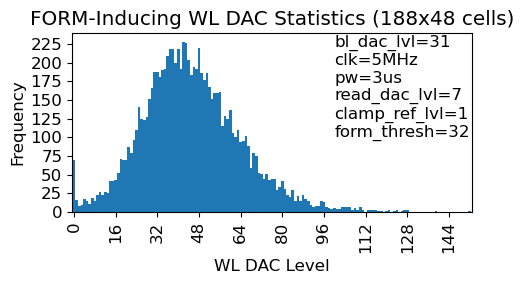

In [3]:
# Load log file
names = ["chip", "time", "addr", "operation", "mask", "wl_dac_lvl", "bsl_dac_lvl", "sa_do", "ignore"]
formdata = pd.read_csv("../data/form/form.5mhz.188cell.csv", names=names, index_col=False)
formdata.sa_do = formdata.sa_do.shift(-1, fill_value=0)
formdata["nform"] = formdata.sa_do.apply(lambda di: bin(di).count("1"))
formdata = formdata[formdata.operation == "SET"]

# Figure for FORM-inducing WL DAC level statistics
plt.figure(figsize=(5,3))
formdata[formdata.operation == "SET"].groupby("wl_dac_lvl").sum()["nform"].plot.bar(width=1)
plt.title("FORM-Inducing WL DAC Statistics (188x48 cells)")
plt.xlabel("WL DAC Level")
plt.ylabel("Frequency")
plt.text(100, 100, "bl_dac_lvl=31\nclk=5MHz\npw=3us\nread_dac_lvl=7\nclamp_ref_lvl=1\nform_thresh=32")
plt.locator_params(nbins=10)
plt.tight_layout()
plt.savefig("figs/form.wl.stats.pdf")

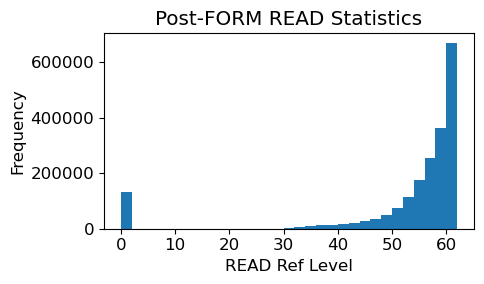

In [4]:
# Load log file
names = ["addr", "time"] + ["read_" + str(i) for i in range(48)]
formreaddata = pd.read_csv("../form.csv", names=names, index_col=False, delimiter="\t")
formdata = np.delete(formreaddata[formreaddata.columns[-48:]].values, [19, 29, 38, 43], axis=1).flatten()

# Figure for post-FORM READ statistics
plt.figure(figsize=(5,3))
plt.hist(formdata,bins=range(0,64,2))
plt.title("Post-FORM READ Statistics")
plt.xlabel("READ Ref Level")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("figs/form.read.stats.pdf")

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32]),
 array([393217,      9,    155,   1207,   5310,  16671,  44445, 104537,
        191192, 343115, 481553, 569819, 505707, 280097, 107617,  48559,
         20631,  17815,   7015,   3590,   1786,    876,    427,    210,
            82,     55,     12,     10,      6,      2,      1]))

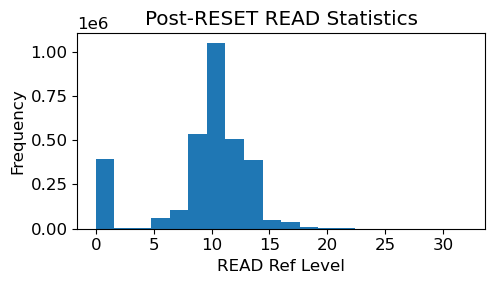

In [6]:
# Load log file
names = ["addr", "time"] + ["read_" + str(i) for i in range(48)]
resetdata = pd.read_csv("../reset.csv", names=names, index_col=False, delimiter="\t")
resetdata = resetdata[resetdata.columns[-48:]].values
# resetdata = np.delete(resetdata[resetdata.columns[-48:]].values, [7, 16, 19, 23, 24, 29, 38, 39, 43], axis=1)
resetdata = resetdata.flatten()

# Figure for post-RESET READ statistics
plt.figure(figsize=(5,3))
plt.hist(resetdata, bins=20)
plt.title("Post-RESET READ Statistics")
plt.xlabel("READ Ref Level")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("figs/reset.read.stats.pdf")
np.unique(resetdata, return_counts=True)

## Checkerboard demo

Here, we plot programmed checkerboard patterns to demonstrate 1-4bpc programmability. We also indicate the Gray code BER and linear root mean squared error (RMSE) of the measured values from the programmed values.

[[1152    0]
 [   0 1152]]
[[576   0   0   0]
 [  0 576   0   0]
 [  0   0 576   0]
 [  0   0   0 576]]


KeyboardInterrupt: 

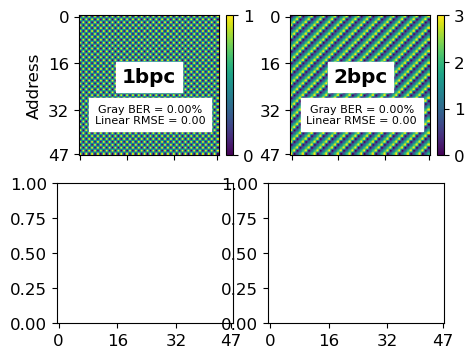

In [13]:
# Produce checkerboard plots for 1-4 bpc
confmats = []
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(5,4))
for bpc in range(1, 5):
  # Subplot
  plt.subplot(220 + bpc)

  # Load data
  names = ["addr", "time"] + ["read_" + str(i) for i in range(48)]
  data = pd.read_csv(f"../data/cb/{bpc}bpc.csv", sep="\t", names=names)

  # Show multi-bit result
  matdata = data[data.columns[-48:]].values[:48]
  im = plt.imshow(matdata, vmin=0, vmax=2**bpc-1)
  cbar = plt.colorbar(im, fraction=0.04, pad=0.04)
  if bpc != 4:
    cbar.set_ticks(range(2**bpc))
  # cbar.set_label("READ Value")
  plt.title(f"{bpc}bpc", x=0.5, y=0.5, verticalalignment="center", horizontalalignment="center", backgroundcolor="white", fontweight="bold")
  if bpc > 2:
    plt.xlabel("Bit Index")
  if bpc % 2 == 1:
    plt.ylabel("Address")

  # Load data into confmat
  confmat = np.zeros(shape=(2**bpc, 2**bpc))
  for i in range(48):
    for j in range(48):
      confmat[(data["addr"][i] + j) % (2**bpc)][matdata[i][j]] += 1
  confmat = confmat.astype(int)
  print(confmat)

  # Symbol error magnitudes
  mae = sum(abs(i - j) * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum()
  rmse = np.sqrt(sum((i - j)**2 * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum())

  # Function to get Gray code string
  getgray = lambda x : format(2**(2**bpc) + x^x//2, f"0{2**bpc-1}b")[1:]

  # Function to get Gray code error rate for each possible symbol confusion
  grayerr = np.array([[sum([int(ic != jc) for ic, jc in zip(getgray(i), getgray(j))]) for i in range(2**bpc)] for j in range(2**bpc)]) / bpc
  # print(grayerr)

  # BER
  ber = (grayerr * confmat).sum() / confmat.sum()
  plt.text(0.5*48, 0.7*48, f"Gray BER = " + format(ber*100, ".2f") + "%\nLinear RMSE = " + format(rmse, ".2f"), fontsize=8, verticalalignment="center", horizontalalignment="center", backgroundcolor="white")

  # Set ticks
  plt.xticks([0,16,32,47])
  plt.yticks([0,16,32,47])
plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0.5)
plt.tight_layout()
plt.savefig("figs/cb.pdf")
plt.show()

def binary_to_gray_op(n):
  n = int(n, 2)
  n ^= (n >> 1)
  return bin(n)[2:]

## Conductance level visualization

Here, we plot the READ/WRITE level boundaries.

FileNotFoundError: [Errno 2] No such file or directory: '../settings/1bpc.json'

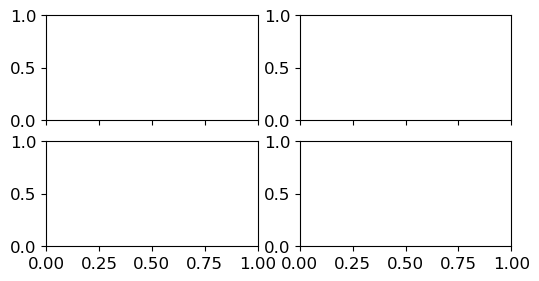

In [ ]:
# Plot conductance ranges
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(6,3))
for bpc in range(1, 5):
    # Subplot
    plt.subplot(220 + bpc)
    
    # Load settings
    settings = json.load(open(f"../settings/{bpc}bpc.json"))
    
    # Plot
    plt.axvline(0, 0, 1, color='r', label="Read Boundary" if bpc == 1 else None)
    for level in settings["level_settings"]:
        plt.axvline(level["adc_upper_read_ref_lvl"], 0, 1, color='r')
        plt.axvline(level["adc_lower_write_ref_lvl"], 0, 0.5, color='g', linestyle='--')
        plt.axvline(level["adc_upper_write_ref_lvl"], 0, 0.5, color='g', linestyle='--', label="Write Boundary" if bpc == 1 and level["adc_upper_write_ref_lvl"] == 63 else None)
    plt.xlim(-0.5, 63.5)
    plt.gca().get_yaxis().set_visible(False)
    plt.title(f"{bpc}bpc Level Allocation", backgroundcolor="white", y=1, pad=-14)
    if bpc > 2:
        plt.xlabel("ADC Level")
lgd = fig.legend(loc="center", bbox_to_anchor=(0.51, 1), ncol=2)
plt.tight_layout()
plt.savefig("figs/levels.pdf", bbox_extra_artists=(lgd,), bbox_inches="tight")
plt.show()

## Endurance

Here, we show so endurance cycling data caused by SET/RESET loops (without verify), with READs performed intermittently.

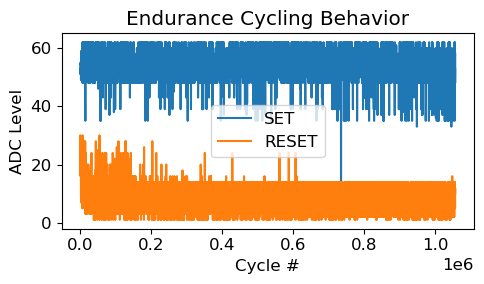

In [ ]:
# Load endurance and show an example
names = ["addr", "i", "Cycle #", "RESET", "SET"]
data = pd.read_csv(f"../data/endurance/endurance.csv.gz", delimiter='\t', names=names)
data = data[data["addr"] == 10900]
data = data[data["i"] == 9]
plt.rcParams["figure.figsize"] = (5,3)
data.groupby("i").plot("Cycle #", ["SET", "RESET"], title="Endurance Cycling Behavior", ylabel="ADC Level")
plt.tight_layout()
plt.savefig("figs/endurance.pdf")
plt.show()

## Retention data
Here, we show the sigma vs. mu for conductance level allocation, and also plot the conductance distributions of each programmed level at time `t`. 

In [ ]:
# Load retention time data
tdata = pd.read_csv("../data/retention/retention4.min.csv.gz")
tdata

,Unnamed: 0,addr,time,lower,upper,width,successes,failures,reads,sets,resets,cycles,read_bits,set_bits,reset_bits,lvl,i,timept
0,0,33416,0.000000,0,1,1,1,1,3975,0,3968,91340,146816,0,146816,8,0,0
1,1,33416,0.000000,0,1,1,1,1,3975,0,3968,91340,146816,0,146816,9,1,0
2,3,33416,0.000000,0,1,1,1,1,3975,0,3968,91340,146816,0,146816,5,3,0
3,4,33416,0.000000,0,1,1,1,1,3975,0,3968,91340,146816,0,146816,6,4,0
4,5,33416,0.000000,0,1,1,1,1,3975,0,3968,91340,146816,0,146816,9,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4849659,3145722,56446,10685.925677,15,61,46,1,0,13,4,0,202,137,26,0,20,42,10000
4849660,3145724,56446,10685.925677,15,61,46,1,0,13,4,0,202,137,26,0,16,44,10000
4849661,3145725,56446,10685.925677,15,61,46,1,0,13,4,0,202,137,26,0,19,45,10000
4849662,3145726,56446,10685.925677,15,61,46,1,0,13,4,0,202,137,26,0,11,46,10000


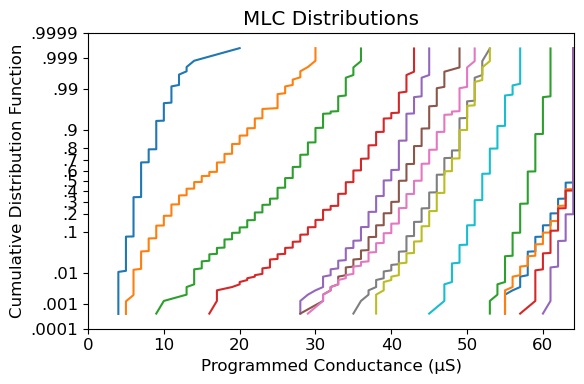

In [ ]:
# Show distribution
for addrmin, addrmax in [(0, 65536)]: # [(0, 30000), [30000, 66000]]: # list(zip(range(0, 65536, 4096), range(4096, 65537, 4096))) + 
    addrstep = 1
    # addrmin, addrmax, addrstep = 0, 65536, 1
    plt.rcParams["figure.figsize"] = [6, 4]
    plt.title("MLC Distributions") # TODO: ADD (1024 cells w/64 levels, ~3hrs)
    # for (lower, upper), d in tdata[(tdata["timept"] == 0) & tdata["addr"].isin(range(addrmin, addrmax, addrstep)) & (tdata["upper"].isin(range(20)) | tdata["lower"].isin(range(55, 65)))].groupby(["lower","upper"]):
    for (lower, upper), d in tdata[(tdata["timept"] == 10000) & tdata["addr"].isin(range(addrmin, addrmax, addrstep)) & tdata["width"].isin(range(8))].groupby(["lower","upper"]):
        if d["failures"].mean() > 0.03:
            continue
        # if (lower, upper) != (0,10) and (lower, upper) != (24,31) and (lower, upper) != (43, 51) and (lower, upper) != (55,58) and (lower, upper) != (63,63):
        #     continue
        # print(d.mean()[["timept","lower","upper","width","successes","failures","reads","sets","resets","cycles","read_bits","set_bits","reset_bits","lvl","time"]].to_dict())
        plt.plot(sorted(d["lvl"].values), np.linspace(0.5/len(d), 1-0.5/len(d), len(d)), label=str((lower,upper))) # symmetric percentile CDF (https://math.stackexchange.com/questions/33488/how-to-calculate-percentile-is-it-possible-to-get-100-percentile)
    plt.xlabel("Programmed Conductance (μS)")
    plt.ylabel("Cumulative Distribution Function")
    plt.gca().set_yscale("ppf")
    # plt.hlines([0.006, 0.994], 0, 256, colors="black", linestyles="--")
    # plt.vlines(np.array([11,35,50,57])*4, 0.001, 0.999, colors="black", linestyles="-", alpha=0.2)
    # plt.xlim(0, 256.1)
    plt.xlim(0, 64.1)
    plt.ylim(0.0001, 0.9999)
    plt.tight_layout()
    plt.savefig("figs/mlcdist.pdf")
    # plt.legend()
    plt.show()

## SET/RESET final conductance sweeps

We test the effect of pulses with different {VWL, VBL, pw, gi} combos on final conductance gf.

### SET sweep

In [54]:
# SET sweep data
setdata = pd.read_csv(f"../set_sweep.csv", delimiter="\t", names=["addr", "t", "vwl", "vbl", "pw"] + [f"gi[{i}]" for i in range(48)] + [f"gf[{i}]" for i in range(48)])
setdata = pd.concat([setdata[["addr","t","vwl","vbl","pw",f"gi[{i}]",f"gf[{i}]"]].rename(columns={f"gi[{i}]" : "gi", f"gf[{i}]" : "gf"}) for i in range(48)])
setdata

,addr,t,vwl,vbl,pw,gi,gf
0,27400,1.700532e+09,0,0,1,12.0,12.0
1,11301,1.700532e+09,0,1,1,12.0,12.0
2,5694,1.700532e+09,0,2,1,14.0,14.0
3,49628,1.700532e+09,0,3,1,14.0,13.0
4,38144,1.700532e+09,0,4,1,10.0,9.0
...,...,...,...,...,...,...,...
16673,58973,1.700533e+09,0,6,1,12.0,22.0
16674,46647,1.700533e+09,0,7,1,15.0,15.0
16675,6448,1.700533e+09,0,8,1,13.0,30.0
16676,3949,1.700533e+09,0,9,1,14.0,40.0


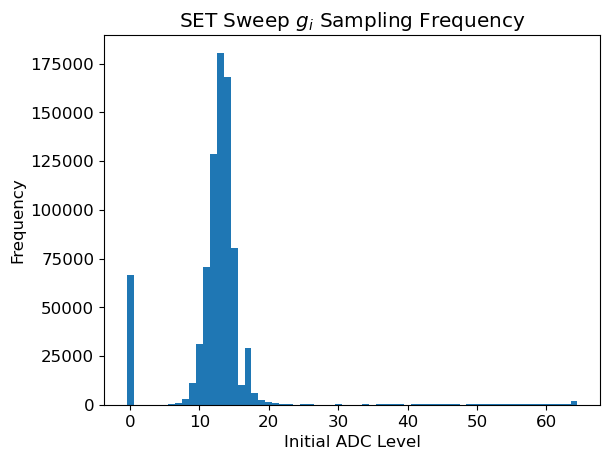

In [55]:
# SET sweep gi sampling frequency check
setdata["gi"].plot.hist(bins=np.arange(-0.5, 65.5))
plt.title("SET Sweep $g_i$ Sampling Frequency")
plt.xlabel("Initial ADC Level")
plt.show()

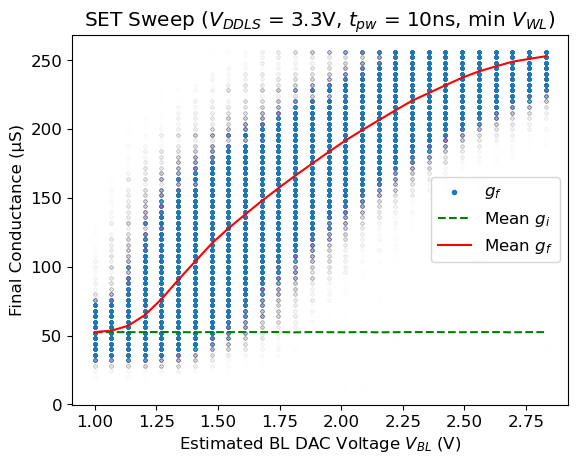

In [74]:
# Plot SET sweep
d = setdata[(setdata["gi"].isin(range(1,20))) & (setdata["pw"] == 1) & (setdata["vwl"] == 0)][["vwl","vbl","pw","gi","gf"]]
d["vbl"] = (d["vbl"]*2.1/31) + 1
fig = plt.figure()
ax = plt.axes()
# ax.scatter(d["vbl"], d["gi"]*4, marker=".", alpha=0.002, label="$g_i$")
ax.scatter(d["vbl"], d["gf"]*4, marker=".", alpha=0.002, label="$g_f$")
# (d.groupby("vbl")["gf"].quantile(0.999) * 4).plot(color="blue", linestyle='--', label="99.9$^{th}$ perc. $g_f$", ax=ax)
(d.groupby("vbl")["gi"].mean() * 4).plot(color="green", linestyle="--", label="Mean $g_i$", rasterized=True)
(d.groupby("vbl")["gf"].mean() * 4).plot(color="red", label="Mean $g_f$", rasterized=True)
ax.set_title(f"SET Sweep ($V_{{DDLS}}$ = {vddio/10}V, $t_{{pw}}$ = 10ns, min $V_{{WL}}$)", y=1)
ax.set_xlabel("Estimated BL DAC Voltage $V_{BL}$ (V)")
ax.set_ylabel("Final Conductance (μS)")
legend = ax.legend(loc="right")
for lh in legend.legendHandles: 
    lh.set_alpha(1)
plt.savefig(f"figs/setsweep{vddio}_bl.pdf")

In [ ]:
# Plot SET sweep
d = setdata[(setdata["gi"].isin(range(1,20))) & (setdata["pw"] == 1) & (setdata["vwl"] == 0)][["vwl","vbl","pw","gi","gf"]]
d["vbl"] = (d["vbl"]*2.1/31) + 1
fig = plt.figure()
ax = plt.axes()
# ax.scatter(d["vbl"], d["gi"]*4, marker=".", alpha=0.002, label="$g_i$")
ax.scatter(d["vbl"], d["gf"]*4, marker=".", alpha=0.002, label="$g_f$")
# (d.groupby("vbl")["gf"].quantile(0.999) * 4).plot(color="blue", linestyle='--', label="99.9$^{th}$ perc. $g_f$", ax=ax)
(d.groupby("vbl")["gi"].mean() * 4).plot(color="green", linestyle="--", label="Mean $g_i$", rasterized=True)
(d.groupby("vbl")["gf"].mean() * 4).plot(color="red", label="Mean $g_f$", rasterized=True)
ax.set_title(f"SET Sweep ($V_{{DDLS}}$ = {vddio/10}V, $t_{{pw}}$ = 10ns, min $V_{{WL}}$)", y=1)
ax.set_xlabel("Estimated BL DAC Voltage $V_{BL}$ (V)")
ax.set_ylabel("Final Conductance (μS)")
legend = ax.legend(loc="right")
for lh in legend.legendHandles: 
    lh.set_alpha(1)
plt.savefig(f"figs/setsweep{vddio}_bl.pdf")

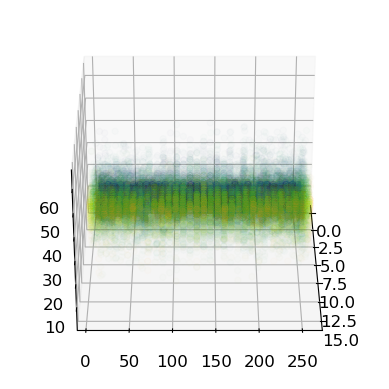

In [78]:
d = setdata[(setdata["gi"].isin(range(1,20))) & (setdata["pw"] == 1) & (setdata["vbl"].isin(range(16))) & (setdata["vwl"] > 0)][["vwl","vbl","pw","gi","gf"]]
ax = plt.axes(projection='3d')
ax.scatter(d["vbl"], d["vwl"], d["gf"], c=d["vbl"], alpha=0.01)
ax.azim = 0
# ax.elev = -30

### RESET sweep

In [79]:
# RESET sweep data
resetdata = pd.read_csv(f"../reset_sweep.csv", delimiter="\t", names=["addr", "t", "vwl", "vsl", "pw"] + [f"gi[{i}]" for i in range(48)] + [f"gf[{i}]" for i in range(48)])
resetdata = pd.concat([resetdata[["addr","t","vwl","vsl","pw",f"gi[{i}]",f"gf[{i}]"]].rename(columns={f"gi[{i}]" : "gi", f"gf[{i}]" : "gf"}) for i in range(48)])
resetdata

,addr,t,vwl,vsl,pw,gi,gf
0,3276,1.700537e+09,0,0,1,47,46.0
1,29620,1.700537e+09,0,1,1,44,44.0
2,3105,1.700537e+09,0,2,1,57,57.0
3,54651,1.700537e+09,0,3,1,30,28.0
4,29301,1.700537e+09,0,4,1,53,53.0
...,...,...,...,...,...,...,...
119356,41696,1.700542e+09,248,28,4,62,17.0
119357,3132,1.700542e+09,248,29,4,14,20.0
119358,37808,1.700542e+09,248,30,4,28,12.0
119359,29418,1.700542e+09,248,31,4,18,16.0


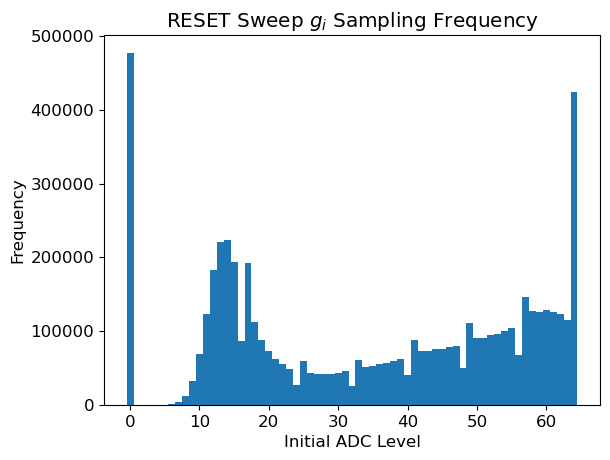

In [80]:
# RESET sweep gi sampling frequency check
plt.figure()
resetdata["gi"].plot.hist(bins=np.arange(-0.5, 65.5))
plt.title("RESET Sweep $g_i$ Sampling Frequency")
plt.xlabel("Initial ADC Level")
plt.show()

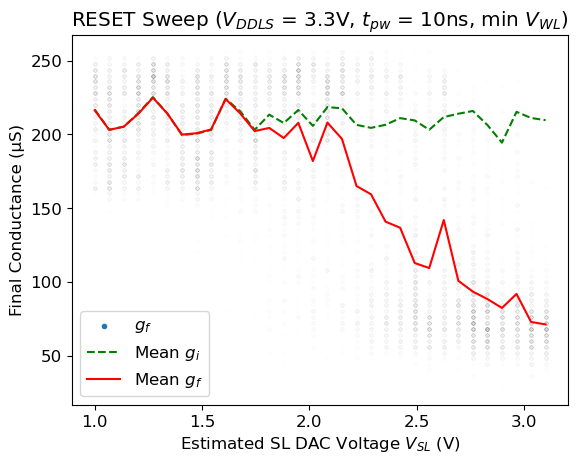

In [84]:
# Plot RESET sweep
d = resetdata[(resetdata["gi"].isin(range(40,63))) & (resetdata["pw"] == 1) & (resetdata["vwl"] == 0)][["vwl","vsl","pw","gi","gf"]]
d["vsl"] = (d["vsl"]*2.1/31) + 1
fig = plt.figure()
ax = plt.axes()
# ax.scatter(d["vsl"], d["gi"]*4, marker=".", alpha=0.002, label="$g_i$")
ax.scatter(d["vsl"], d["gf"]*4, marker=".", alpha=0.002, label="$g_f$")
(d.groupby("vsl")["gi"].mean() * 4).plot(color="green", linestyle="--", label="Mean $g_i$", rasterized=True)
(d.groupby("vsl")["gf"].mean() * 4).plot(color="red", label="Mean $g_f$", rasterized=True)
ax.set_title(f"RESET Sweep ($V_{{DDLS}}$ = {vddio/10}V, $t_{{pw}}$ = 10ns, min $V_{{WL}}$)", y=1)
ax.set_xlabel("Estimated SL DAC Voltage $V_{SL}$ (V)")
ax.set_ylabel("Final Conductance (μS)")
legend = ax.legend()
for lh in legend.legendHandles: 
    lh.set_alpha(1)
plt.savefig(f"figs/resetsweep{vddio}_sl.pdf")

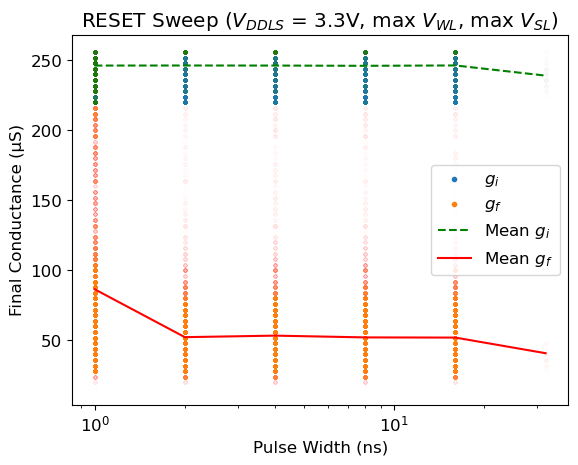

: 

In [7]:
# Plot RESET PW sweep
d = resetdata[resetdata["gi"].isin(range(40,50)) & resetdata["vsl"].isin([31]) & (resetdata["vwl"] == 0)][["vwl","vsl","pw","gi","gf"]]
fig = plt.figure()
ax = plt.axes()
ax.scatter(d["pw"], d["gi"]*4, marker=".", alpha=0.002, label="$g_i$")
ax.scatter(d["pw"], d["gf"]*4, marker=".", alpha=0.002, label="$g_f$")
(d.groupby("pw")["gi"].mean() * 4).plot(color="green", linestyle="--", label="Mean $g_i$")
(d.groupby("pw")["gf"].mean() * 4).plot(color="red", label="Mean $g_f$")
ax.set_title(f"RESET Sweep ($V_{{DDLS}}$ = {vddio/10}V, max $V_{{WL}}$, max $V_{{SL}}$)", y=1)
ax.set_xlabel("Pulse Width (ns)")
ax.set_xscale("log")
ax.set_ylabel("Final Conductance (μS)")
legend = ax.legend()
for lh in legend.legendHandles: 
    lh.set_alpha(1)
plt.savefig(f"figs/resetsweep{vddio}_pw.pdf")

## SET/RESET Power

In this section, we measure SET/RESET power across different pulse conditions.

### SET Pulse Power

In [ ]:
# Load data and convert voltage/current to power
edatas = []
for i in range(3):
    vs = ["vdd", "vdd_dac", "vsa", "vddio", "vddio_dac"]
    edata = pd.read_csv(f"../data/power/setpower{vddio}_x{i}.csv", delimiter="\t", names=["time", "vwl", "vbl", "pw", "i(vdd)", "i(vdd_dac)", "i(vsa)", "i(vddio)", "i(vddio_dac)", "v(vddio)", "v(vddio_dac)"])
    edata["v(vdd)"] = edata["v(vdd_dac)"] = edata["v(vsa)"] = 0.9
    for v in vs:
      edata[f"p({v})"] = edata[f"v({v})"] * edata[f"i({v})"]
    edata["totpow"] = sum([edata[f"p({v})"] for v in vs])
    edata["n"] = i
    edatas.append(edata)
edata = pd.concat(edatas)
edata

In [ ]:
# 3-D plot of pulse power vs. {VWL, VBL, number of bits unmasked}
fig = plt.figure(figsize=(5.5, 4.5))
ax = plt.axes(projection='3d')
ax.set_title(f"SET Pulse Power ($V_{{DDLS}}$ = {vddio/10}V, $t_{{pw}}$ = 40µs, HRS)", y=1)
ax.set_xlabel("BL DAC Level")
ax.set_ylabel("WL DAC Level")
ax.set_zlabel("Total Power (mW)")
for i in range(3):
    e = edata[edata['n'] == i]
    surf = ax.plot_trisurf(e['vbl'], e['vwl'], e['totpow'] * 1000, label=f"{i} unmasked bits", alpha=0.75)
    surf._facecolors2d = surf._facecolor3d
    surf._edgecolors2d = surf._edgecolor3d
ax.legend(loc=(0.05, 0.7))
plt.tight_layout()
plt.savefig(f"figs/setpower{vddio}.pdf")
plt.show()

### RESET Pulse Power

In [ ]:
# Load data and convert voltage/current to power
edatas = []
for i in range(3):
    vs = ["vdd", "vdd_dac", "vsa", "vddio", "vddio_dac"]
    edata = pd.read_csv(f"../data/power/resetpower{vddio}_x{i}.csv", delimiter="\t", names=["time", "vwl", "vsl", "pw", "i(vdd)", "i(vdd_dac)", "i(vsa)", "i(vddio)", "i(vddio_dac)", "v(vddio)", "v(vddio_dac)"])
    edata["v(vdd)"] = edata["v(vdd_dac)"] = edata["v(vsa)"] = 0.9
    for v in vs:
      edata[f"p({v})"] = edata[f"v({v})"] * edata[f"i({v})"]
    edata["totpow"] = sum([edata[f"p({v})"] for v in vs])
    edata["n"] = i
    edatas.append(edata)
edata = pd.concat(edatas)
edata

In [ ]:
# 3-D plot of pulse power vs. {VWL, VSL, number of bits unmasked}
fig = plt.figure(figsize=(5.5, 4.5))
ax = plt.axes(projection='3d')
ax.set_title(f"RESET Pulse Power ($V_{{DDLS}}$ = {vddio/10}V, $t_{{pw}}$ = 40µs, LRS)", y=1)
ax.set_xlabel("SL DAC Level")
ax.set_ylabel("WL DAC Level")
ax.set_zlabel("Total Power (mW)")
for i in range(3):
    e = edata[edata['n'] == i]
    surf = ax.plot_trisurf(e['vsl'], e['vwl'], e['totpow'] * 1000, label=f"{i} unmasked bits", alpha=0.75)
    surf._facecolors2d = surf._facecolor3d
    surf._edgecolors2d = surf._edgecolor3d
ax.legend(loc=(0.05, 0.7))
plt.tight_layout()
plt.savefig(f"figs/resetpower{vddio}.pdf")
plt.show()